## Homework

Download IBM, McDonalds and Microsoft stock price data for a period of '2017-07-01','2020-06-30' and calculate VaR curves for a portfolio (with weights $w_i=1/p_i$) using different approaches:

1. Use multivariate normal (as in the class)
2. Use Historical simulation (modify the implementation from the univariate case)
3. For both approaches, calculate ES curves and plot them as well (take conditional mean, not the single quantile)
4. Optionally, backtest ES

Then plot all VaR and ES curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR and ES curves
2. p-value for each model you use for VaR tests
3. Optionally, p-value for each model you use for ES tests
4. Conclusion about what approach is the most suitable for this portfolio

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf 
from arch import arch_model
import scipy.stats as ss
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

In [23]:
alpha = 0.05

def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__) 

In [24]:
selected_companies = ['IBM',  'MCD', 'MSFT']

dwj_companies = 'VZ UNH JNJ PG MRK RTX KO WBA MMM WMT MSFT IBM INTC AAPL CSCO '
dwj_companies += 'NKE CAT PFE XOM MCD JPM HD V GS DIS AXP CVX TRV BA' # DOW

prices = yf.download(dwj_companies, '2017-07-01','2020-06-30' , group_by="column")['Adj Close'].dropna()

prices.head()

[*********************100%***********************]  29 of 29 completed


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-30,34.228165,78.866081,186.335297,96.453606,27.254623,86.129616,101.747154,205.542801,138.797165,126.135620,...,27.155567,77.240051,69.332275,114.349983,173.863464,91.289307,36.567341,68.315224,69.627838,64.180756
2017-07-03,34.104580,79.671204,187.126801,96.013756,27.280743,87.755951,102.905869,210.526260,139.349075,127.570549,...,27.341511,77.762962,69.315247,115.082024,175.016754,90.870735,36.845737,68.158195,69.333443,65.269905
2017-07-05,34.244797,79.774574,190.160950,96.480499,27.342268,86.369019,101.153419,211.230225,138.154739,126.004402,...,27.195992,77.700920,69.718369,114.205391,176.517059,91.513206,36.559162,68.603104,69.296623,64.276131
2017-07-06,33.921581,78.693886,189.849991,95.600891,26.999496,85.708588,99.706306,209.979767,137.575668,124.930275,...,26.856447,77.435028,69.207352,114.033699,175.288727,90.773392,36.101254,67.800529,69.434639,63.695797
2017-07-07,34.266193,79.248329,190.688644,95.968895,27.157696,85.436142,99.677361,208.673676,137.738541,125.405838,...,26.961544,77.683197,69.616173,114.928391,176.245117,91.425606,36.068069,67.582428,69.305824,63.775299


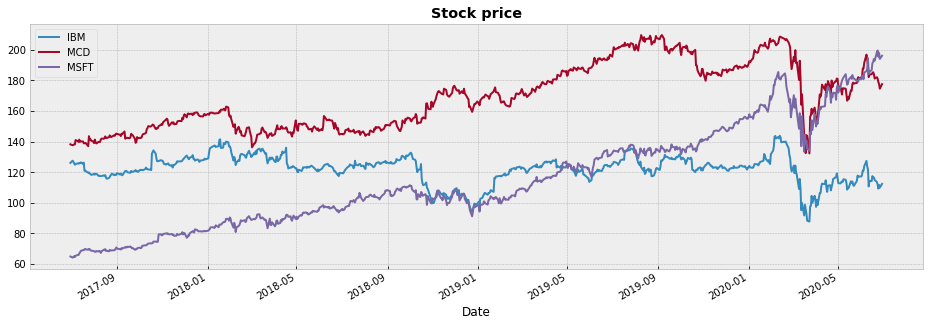

In [25]:
prices.loc[:,selected_companies].plot(figsize=(16, 5))
plt.title("Stock price", weight="bold");

In [26]:
# Convert datetime index to period
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
               '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=754, freq=None)
PeriodIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
             '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
             '2017-07-13', '2017-07-14',
             ...
             '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
             '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
             '2020-06-26', '2020-06-29'],
            dtype='period[D]', name='Date', length=754, freq='D')


In [27]:
returns = prices.pct_change().dropna()
returns.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-03,-0.003611,0.010209,0.004248,-0.004560,0.000958,0.018882,0.011388,0.024245,0.003976,0.011376,...,0.006847,0.006770,-0.000246,0.006402,0.006633,-0.004585,0.007613,-0.002299,-0.004228,0.016970
2017-07-05,0.004111,0.001297,0.016214,0.004861,0.002255,-0.015804,-0.017030,0.003344,-0.008571,-0.012277,...,-0.005322,-0.000798,0.005816,-0.007617,0.008572,0.007070,-0.007778,0.006528,-0.000531,-0.015226
2017-07-06,-0.009438,-0.013547,-0.001635,-0.009117,-0.012536,-0.007647,-0.014306,-0.005920,-0.004191,-0.008525,...,-0.012485,-0.003422,-0.007330,-0.001503,-0.006959,-0.008084,-0.012525,-0.011699,0.001992,-0.009029
2017-07-07,0.010159,0.007046,0.004417,0.003849,0.005859,-0.003179,-0.000290,-0.006220,0.001184,0.003807,...,0.003913,0.003205,0.005907,0.007846,0.005456,0.007185,-0.000919,-0.003217,-0.001855,0.001248
2017-07-10,0.006104,-0.000356,0.007857,0.008604,0.002589,-0.004348,0.002613,0.002486,-0.006898,0.003139,...,0.001799,-0.006389,0.003670,-0.011009,-0.005373,0.012457,-0.006440,-0.004001,-0.027877,-0.000748


In [28]:
# w = np.ones(shape=(returns.shape[1],)) / returns.shape[1]

w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

# w_temp = np.ones(shape=(len(selected_companies),)) / len(selected_companies)

w_temp = 1 / prices[selected_companies].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[selected_companies].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

AAPL    0.066223
AXP     0.028741
BA      0.012165
CAT     0.023500
CSCO    0.083167
CVX     0.026317
DIS     0.022278
GS      0.011028
HD      0.016331
IBM     0.017970
INTC    0.074701
JNJ     0.019168
JPM     0.028107
KO      0.058032
MCD     0.016396
MMM     0.012396
MRK     0.042220
MSFT    0.034890
NKE     0.040134
PFE     0.083470
PG      0.029346
RTX     0.032693
TRV     0.019822
UNH     0.013037
V       0.024830
VZ      0.061986
WBA     0.033180
WMT     0.032554
XOM     0.035317
Name: 2017-06-30, dtype: float64
IBM     0.259473
MCD     0.236748
MSFT    0.503780
Name: 2017-06-30, dtype: float64


## Use multivariate normal

In [46]:
def make_mult_normal_simulations(returns, n_samples=10**3):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [47]:
VaR_multi_normal = calc_VaR(returns[selected_companies], make_mult_normal_simulations, w=w_temp)

## Use Historical simulation

In [104]:
def make_HS(returns):
    
    return_simulations = pd.DataFrame(returns, columns=returns.columns)

    return return_simulations

In [49]:
def calc_VaR_HS(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]       
        return_simulations = sampling_fun(history)                  
        portfolio_simulated_returns = np.dot(history.values, w)
        VaR[i] = np.quantile(portfolio_simulated_returns, level)
         
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

In [50]:
VaR_HS = calc_VaR_HS(returns[selected_companies], make_HS, w=w_temp)

## For both approaches, calculate ES curves and plot them as well 

In [51]:
def calc_ES(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    ES =  np.full(r.shape[0], np.nan)
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
    
        ES[i] = portfolio_simulated_returns[portfolio_simulated_returns < VaR[i]].mean()
        
    return pd.Series(data=ES, index=r.index, name=sampling_fun.__name__)

In [52]:
ES_multi_normal = calc_ES(returns[selected_companies], make_mult_normal_simulations, w=w_temp)
ES_HS = calc_ES(returns[selected_companies], make_HS, w=w_temp)

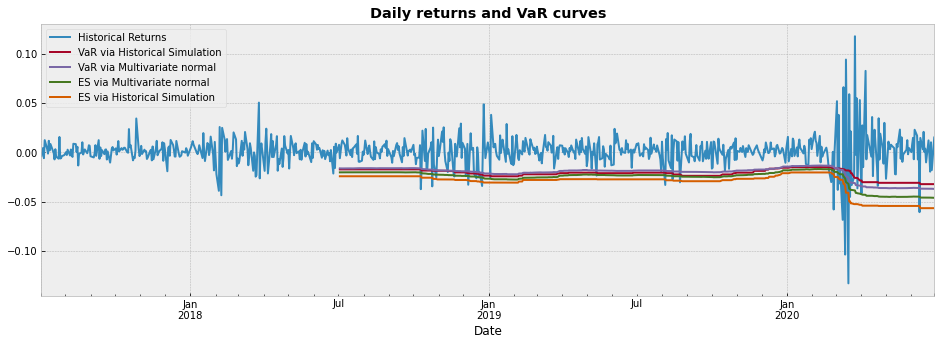

In [53]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
VaR_HS.plot()
VaR_multi_normal.plot()
ES_multi_normal.plot()
ES_HS.plot()
plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Multivariate normal',
            'ES via Multivariate normal',
            'ES via Historical Simulation'])

plt.show()

In [99]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [102]:
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')


In [105]:
backtest_VaR(portfolio_real_returns_selected, VaR_HS, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_multi_normal, 1-alpha)


Backtesting make_HS:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465
Backtesting make_mult_normal_simulations:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465


Вывод: мы видим, что подход симуляции исторических данных и многомерного нормального распределения дает одинаковый результат в оценке VAR. Однако, при оценке ES результат на исторических данных показывает себя лучше. Что позволяет нам лучше оценивать самые худшие случаи просадок ниже ES. 

## Homework

Download IBM, McDonalds and Microsoft stock price data for a period of '2017-07-01','2020-06-30' and calculate VaR curves for a portfolio (with weights $w_i=1/p_i$) using different approaches:

1. Use Historical simulation (modify the implementation from the univariate case)
2. Use GMM model. Select the optimal number of components using AIC or BIC criteria
3. Use Copula+GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals. Select the optimal copula type (fit different copula models and select the one with the highest Log Likelihood)
4. Optionally, use Copula+GARCH model and select the optimal copula type and GARCH parameters (fit different GARCH models and select the one with the highest Log Likelihood, then for standardized residuals fit different copula models and select the one with the highest Log Likelihood)


Then plot all VaR curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR curves
2. p-value for each model you use
3. Conclusion about what approach is the most suitable for this stock

# GMM model

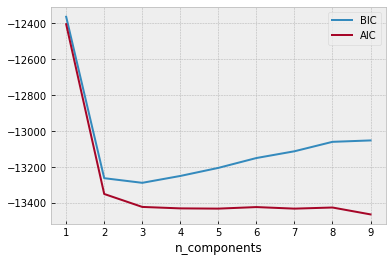

In [111]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(returns[selected_companies].values)
          for n in n_components]

plt.plot(n_components, [m.bic(returns[selected_companies].values) for m in models], label='BIC')
plt.plot(n_components, [m.aic(returns[selected_companies].values) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [112]:
from sklearn.mixture import GaussianMixture

n_samples = 10 ** 4

gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, random_state=42) # full spherical
gmm.fit(returns[selected_companies].values)

return_simulations = gmm.sample(n_samples=n_samples)[0]

return_simulations = pd.DataFrame(return_simulations, columns=selected_companies)

In [114]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

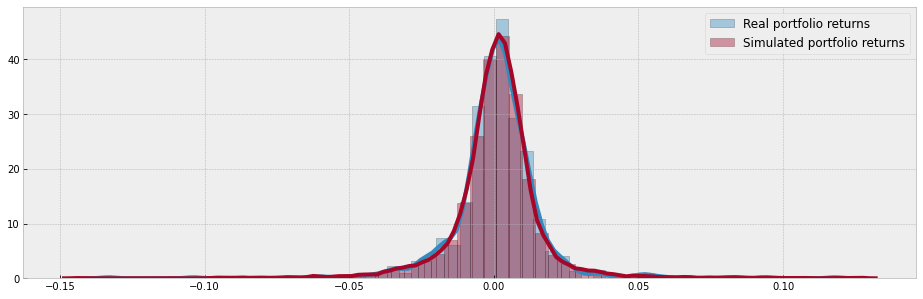

In [115]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [116]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.022058039600775174
-0.02272851083098383


In [188]:
def make_gmm_simulations(returns, n_samples=10**3):

    n_components = 3

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=3, random_state=42) # full spherical
    gmm.fit(returns.values)

    return_simulations = gmm.sample(n_samples=n_samples)[0]

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [189]:
VaR_gmm_3 = calc_VaR(returns[selected_companies], make_gmm_simulations, w_temp)

# Copula+GARCH model

С точки зрения likelihood оптимальной является StudentCopula.

In [172]:
import scipy.stats as ss

cdfs = returns[selected_companies].copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [173]:
distribution_params

{'IBM': (1.9925490863127018, 0.0005890549566403525, 0.00849862760442413),
 'MCD': (2.2648935245584685, 0.0007288798275608387, 0.007639950063124217),
 'MSFT': (2.3778656626913586, 0.0020443634645050867, 0.010093509013846109)}

In [174]:
from copulae import StudentCopula

cop = StudentCopula(dim=cdfs.shape[1])
cop.fit(cdfs)

cop.summary()

              IBM         MCD        MSFT
count  753.000000  753.000000  753.000000
mean     0.500000    0.500000    0.500000
std      0.288484    0.288484    0.288484
min      0.001326    0.001326    0.001326
25%      0.250663    0.250663    0.250663
50%      0.500000    0.500000    0.500000
75%      0.749337    0.749337    0.749337
max      0.998674    0.998674    0.998674


1.000000,0.361121,0.590277
0.361121,1.000000,0.419884
0.590277,0.419884,1.000000


In [175]:
n_samples = 10 ** 4

copula_simulations = cop.random(n_samples, seed=42)

copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

In [176]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = ss.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

In [ ]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [177]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

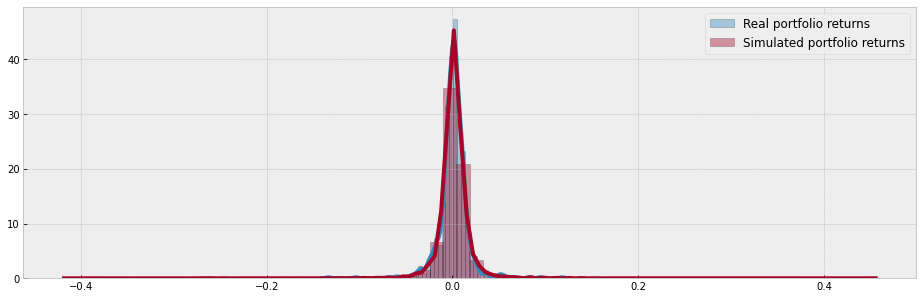

In [178]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [193]:
from arch import arch_model 

def get_garch_residuals(ret, dist):

    scaling_const = 10.0 / ret.std()
    
    # объявляем GARCH модель
        
    am = arch_model(ret * scaling_const,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    #res = am.fit(update_freq=0, disp='off')
    res = am.fit(disp='off', tol=0.1)

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])
        
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [194]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res, scaling_const)
            cdfs[col] = cdf

    # фитим копулу
    cop.fit(cdfs)
    

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, scaling_const = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [195]:
return_simulations = make_copula_simulation(returns[selected_companies], StudentCopula,
                                            n_samples=10**4, univariate_dist='garch')

              IBM         MCD        MSFT
count  753.000000  753.000000  753.000000
mean     0.500000    0.500000    0.500000
std      0.288484    0.288484    0.288484
min      0.001326    0.001326    0.001326
25%      0.250663    0.250663    0.250663
50%      0.500000    0.500000    0.500000
75%      0.749337    0.749337    0.749337
max      0.998674    0.998674    0.998674


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [196]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

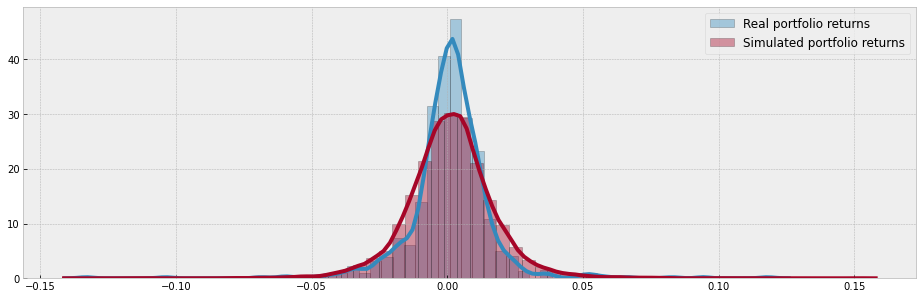

In [197]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [198]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.022058039600775174
-0.024382688242328813


In [199]:
def make_copula_simulation_wrap(returns):
    return_simulations = make_copula_simulation(returns, StudentCopula,
                                            n_samples=10**3, univariate_dist='garch')
    
    return return_simulations

VaR_copulastudent_garch = calc_VaR(returns[selected_companies], make_copula_simulation_wrap, w_temp)

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047

D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
D:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. A

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
C:\Users\egoro\AppData\Roaming\Python\Python38\site-packages\copulae\stats\_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


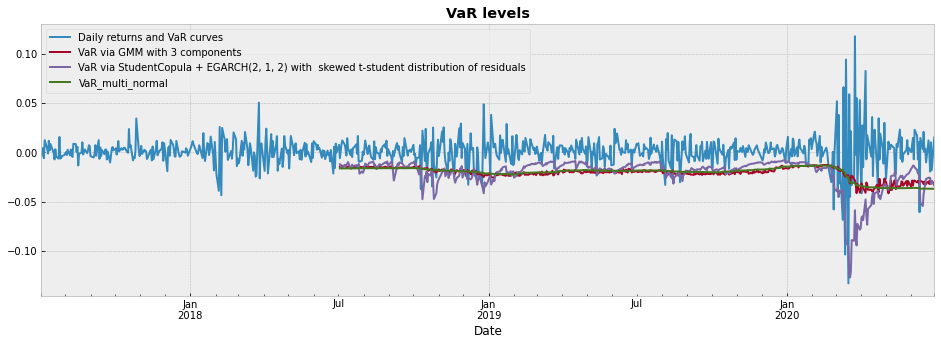

In [203]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()

VaR_gmm_3.plot()
VaR_copulastudent_garch.plot()
VaR_multi_normal.plot()

plt.title("VaR levels", weight="bold")

plt.legend(['Daily returns and VaR curves',
            'VaR via GMM with 3 components',
           'VaR via StudentCopula + EGARCH(2, 1, 2) with  skewed t-student distribution of residuals',
           'VaR_multi_normal'])

plt.show()

In [202]:
backtest_VaR(portfolio_real_returns_selected, VaR_HS, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_gmm_3, 1-alpha)
backtest_VaR(portfolio_real_returns_selected, VaR_copulastudent_garch, 1-alpha)

Backtesting make_HS:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465
Backtesting make_gmm_simulations:
The proportion of hits is 6.99% instead of expected 5.0%
Two-sided p-val 0.0504, one-sided: 0.031
Backtesting make_copula_simulation_wrap:
The proportion of hits is 7.39% instead of expected 5.0%
Two-sided p-val 0.0181, one-sided: 0.0128


Вывод:лучшими показателями с точки зрения риск метрик обладает подход на основе многомерного нормального распределения. Подход с Garch и копулой хоть и хорошо выглядит на графике, но работает с запозданием. 